In [1]:
import os
import numpy as np
import yaml
import pprint
import matplotlib.pyplot as plt
import utils.signals.gps_l1ca as gps_l1ca
import utils.sample_processing.sample_streaming as sample_streaming
import utils

In [2]:
# Get local-data directory for storing downloaded data files
data_dir = os.path.join(os.path.dirname(os.path.dirname(utils.__file__)), "local-data")
os.makedirs(data_dir, exist_ok=True)
raw_collects_dir = os.path.join(data_dir, "raw-collects")
os.makedirs(raw_collects_dir, exist_ok=True)
raw_collect_filenames = sorted(os.listdir(raw_collects_dir))
print(f"Data directory: {data_dir}")
collect_metadata_filepath = os.path.join(raw_collects_dir, "metadata.yml")
with open(collect_metadata_filepath, "r") as f:
    collect_metadata = yaml.safe_load(f)
# pprint.pprint(collect_metadata)
collect_filepaths = {
    collect_id: os.path.join(raw_collects_dir, collect_info["filename"])
    for collect_id, collect_info in collect_metadata["collections"].items()
}

samp_rate = collect_metadata["samp_rate"]
sample_params_dict = collect_metadata["sample_params"]
sample_params = sample_streaming.SampleParameters.from_dict(sample_params_dict)
print(f"Sample rate: {samp_rate/1e6} MHz")
# pprint.pprint(sample_params_dict)
pprint.pprint(sample_params)

collect_id_list = sorted(collect_filepaths.keys())
print("Available collects:")
for collect_id in collect_id_list:
    print(f"  {collect_id}: {os.path.basename(collect_filepaths[collect_id])}")

collect_id = collect_id_list[0]
collect_filepath = collect_filepaths[collect_id]
print(f"Using collect ID: {collect_id}")
# print(f"  Filepath: {collect_filepath}")

Data directory: /home/brianbw/projects/fall-2025-lectures/local-data
Sample rate: 25.0 MHz
SampleParameters(bit_depth=4,
                 is_complex=True,
                 is_integer=True,
                 is_signed=True,
                 is_i_lsb=True)
Available collects:
  20220513_173218_USRP2: CO_A2_20220513_173218_000211_G1_B1_USRP2.sc4
Using collect ID: 20220513_173218_USRP2


In [ ]:
buffer_duration_ms = 20
buffer_size_samples = int(samp_rate * buffer_duration_ms / 1e3)
buffer_size_bytes = sample_streaming.compute_sample_array_size_bytes(
    buffer_size_samples, sample_params.bit_depth, sample_params.is_complex
)
byte_buffer = bytearray(buffer_size_bytes)
sample_buffer = np.zeros(buffer_size_samples, dtype=np.complex64)

with open(collect_filepath, "rb") as f:
    f.readinto(byte_buffer)

# print(len(byte_buffer), len(sample_buffer.data))
sample_streaming.convert_to_complex64_samples(
    byte_buffer,
    sample_buffer,
    sample_params
)

500000 500000


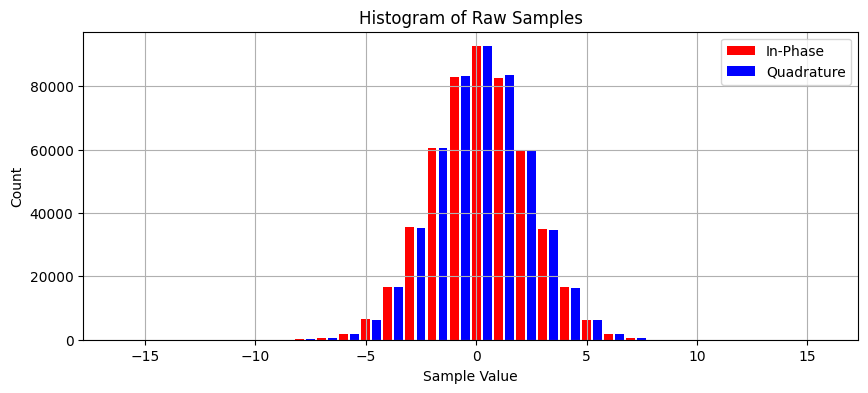

In [16]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
hist_bins = np.arange(-16, 17)
ax.hist(sample_buffer.real, bins=hist_bins, rwidth=0.4, color="r", align="left", label="In-Phase")
ax.hist(sample_buffer.imag, bins=hist_bins, rwidth=0.4, color="b", align="mid", label="Quadrature")
ax.set_title("Histogram of Raw Samples")
ax.set_xlabel("Sample Value")
ax.set_ylabel("Count")
ax.legend()
ax.grid()
plt.show()